In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [2, 5, 10, 25, 50, 100, 200] 
roc_periods = [5, 10]
multiplier = 20
bankroll = 15000
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract_all = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract_all.loc['20180901': '20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

38991.58765879901

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [8]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [9]:
vols = vol(data, vol_lookback)

In [10]:
emas = (pd.DataFrame([ema(data, p, smooth, vols) for p in multi_periods]).T.iloc[max(multi_periods):]).reset_index(drop=True)


In [11]:
emas_adjustments = 10/emas.abs().mean()
emas_adjustments

ema_2      16.547564
ema_5      10.649946
ema_10      7.455656
ema_25      4.601485
ema_50      3.197934
ema_100     2.366622
ema_200     1.913403
dtype: float64

In [12]:
scaled_emas = (emas * emas_adjustments).clip(lower=-20, upper=20)

In [13]:
scaled_emas.abs().mean()

ema_2      9.450422
ema_5      9.471069
ema_10     9.473343
ema_25     9.650008
ema_50     9.792693
ema_100    9.822326
ema_200    9.767722
dtype: float64

In [14]:
target_vol = scaled_emas.abs().std().mean()
target_vol

6.056710256730445

In [15]:
scaled_emas.corr()

,ema_2,ema_5,ema_10,ema_25,ema_50,ema_100,ema_200
ema_2,1.000000,0.755617,0.453709,0.175478,0.072897,0.013282,-0.031253
ema_5,0.755617,1.000000,0.858933,0.468553,0.233487,0.079139,-0.021046
ema_10,0.453709,0.858933,1.000000,0.773297,0.471890,0.208830,0.026284
ema_25,0.175478,0.468553,0.773297,1.000000,0.862827,0.545017,0.221979
ema_50,0.072897,0.233487,0.471890,0.862827,1.000000,0.856503,0.529715
ema_100,0.013282,0.079139,0.208830,0.545017,0.856503,1.000000,0.856996
ema_200,-0.031253,-0.021046,0.026284,0.221979,0.529715,0.856996,1.000000


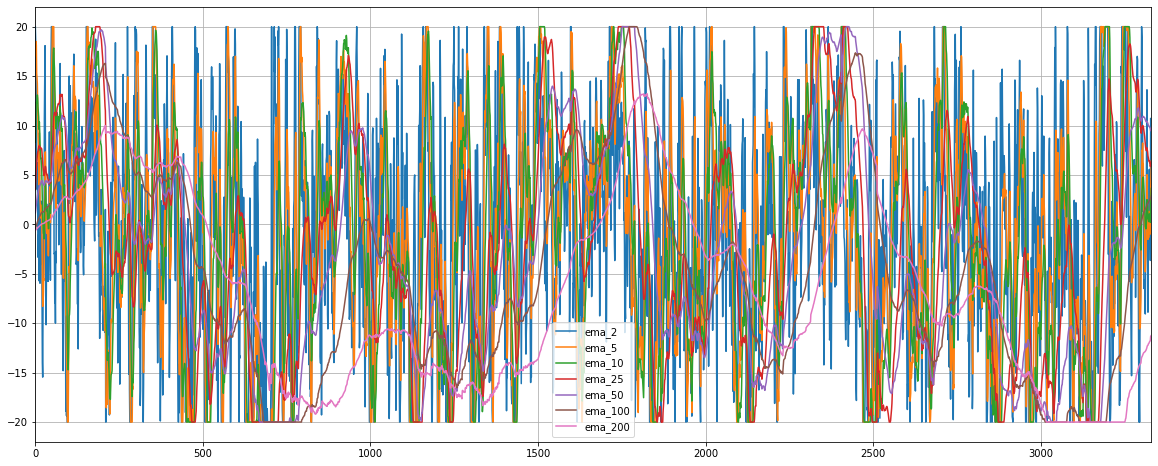

In [16]:
scaled_emas.plot(figsize=(20,8), grid=True);

In [17]:
scaled_emas_combined = scaled_emas.mean(axis=1)

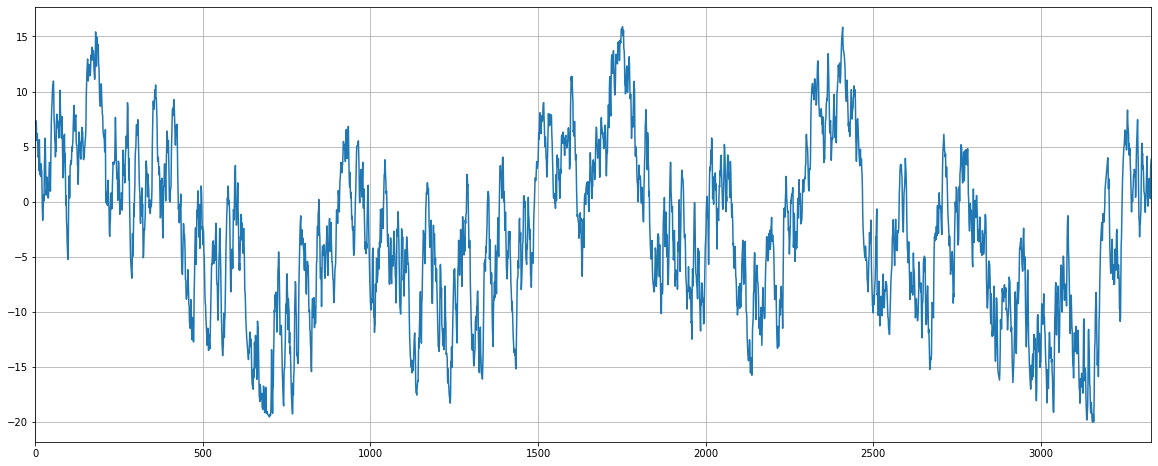

In [18]:
scaled_emas_combined.plot(figsize=(20,8), grid=True);

In [19]:
scaled_emas_combined.abs().mean()

6.660326309515567

In [20]:
scaled_emas_combined.abs().std()

4.644317728081463

In [21]:
multiplier = target_vol/scaled_emas_combined.abs().std()
multiplier

1.304111951710167

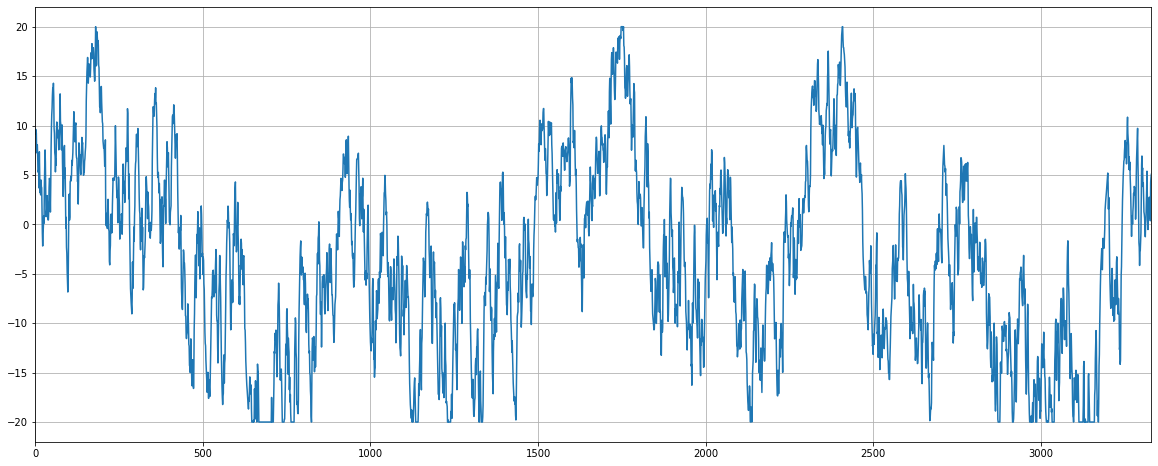

In [22]:
ema_forecast = (multiplier*scaled_emas_combined).clip(lower=-20, upper=20)
ema_forecast.plot(figsize=(20,8), grid=True);

In [23]:
ema_forecast.abs().mean(), ema_forecast.abs().std()

(8.554918585310372, 5.762444353213949)

In [24]:
contract_oos = contract_all.loc['20190101': '20191231']

In [25]:
vol_candles_oos = group_by_volume(contract_oos, avg_vol)
vol_candles_oos['atr'] = get_ATR(vol_candles_oos, atr_periods)
data_oos = pd.DataFrame({'date': vol_candles_oos.date,
                     'open': vol_candles_oos.open,
                     'close': vol_candles_oos.close})
vols_oos = vol(data_oos, vol_lookback)
emas_oos = pd.DataFrame([ema(data_oos, p, smooth, vols_oos) for p in multi_periods]).T
scaled_emas_oos = (emas_oos * emas_adjustments).clip(lower=-20, upper=20)
scaled_emas_combined_oos = scaled_emas_oos.mean(axis=1)
ema_forecast_oos = (multiplier*scaled_emas_combined_oos).clip(lower=-20, upper=20)

In [26]:
scaled_emas_oos.abs().mean()

ema_2       9.060661
ema_5       9.306803
ema_10      9.495611
ema_25      9.393941
ema_50      9.658978
ema_100    10.698473
ema_200    12.645654
dtype: float64

In [27]:
scaled_emas_oos.abs().std()

ema_2      6.130475
ema_5      6.191449
ema_10     6.188734
ema_25     6.137755
ema_50     5.702095
ema_100    6.139327
ema_200    6.431933
dtype: float64

In [28]:
scaled_emas_oos.corr()

,ema_2,ema_5,ema_10,ema_25,ema_50,ema_100,ema_200
ema_2,1.000000,0.757482,0.451636,0.158123,0.051892,0.013586,0.009765
ema_5,0.757482,1.000000,0.858455,0.457441,0.211179,0.084939,0.041174
ema_10,0.451636,0.858455,1.000000,0.767597,0.451659,0.216795,0.099124
ema_25,0.158123,0.457441,0.767597,1.000000,0.853897,0.545565,0.285903
ema_50,0.051892,0.211179,0.451659,0.853897,1.000000,0.854496,0.561403
ema_100,0.013586,0.084939,0.216795,0.545565,0.854496,1.000000,0.864593
ema_200,0.009765,0.041174,0.099124,0.285903,0.561403,0.864593,1.000000


In [29]:
ema_forecast_oos.abs().mean(), ema_forecast_oos.std()

(9.276533795197304, 10.009709848332465)

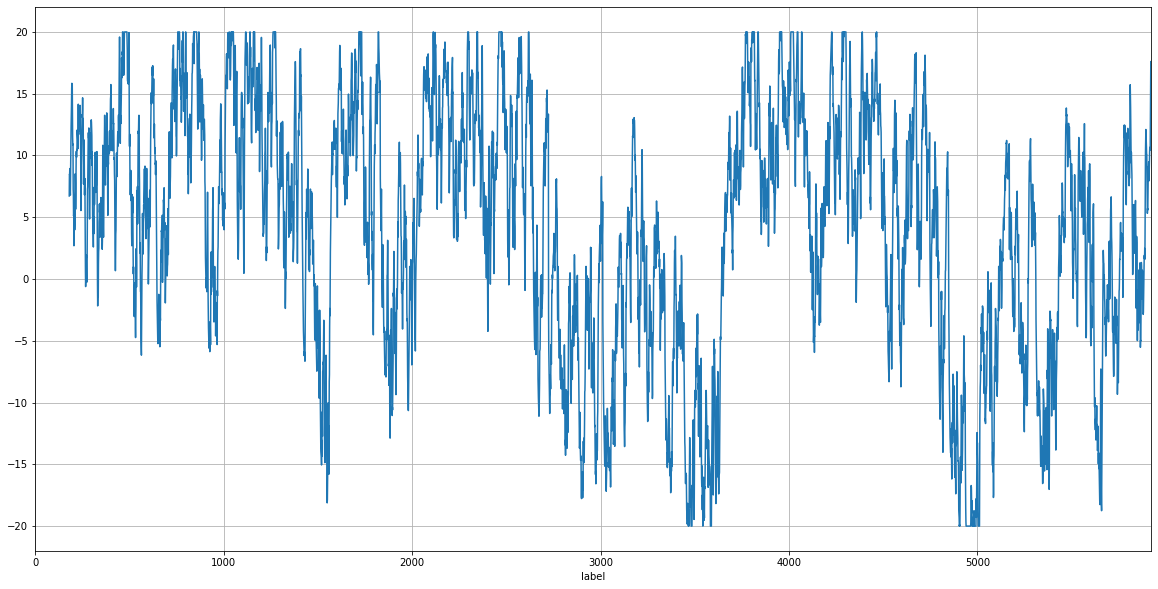

In [30]:
ema_forecast_oos.plot(figsize=(20,10), grid=True);

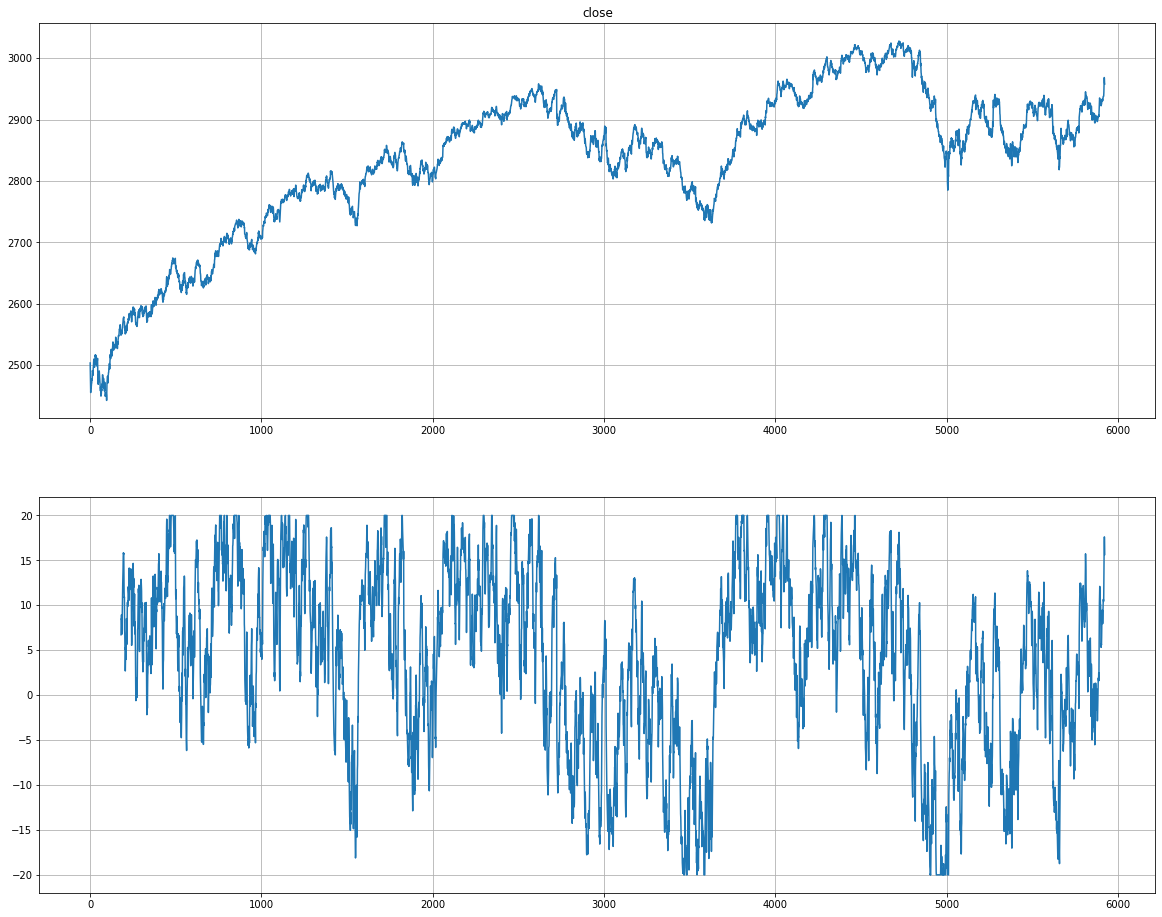

In [31]:
plot(vol_candles_oos.close, ema_forecast_oos)

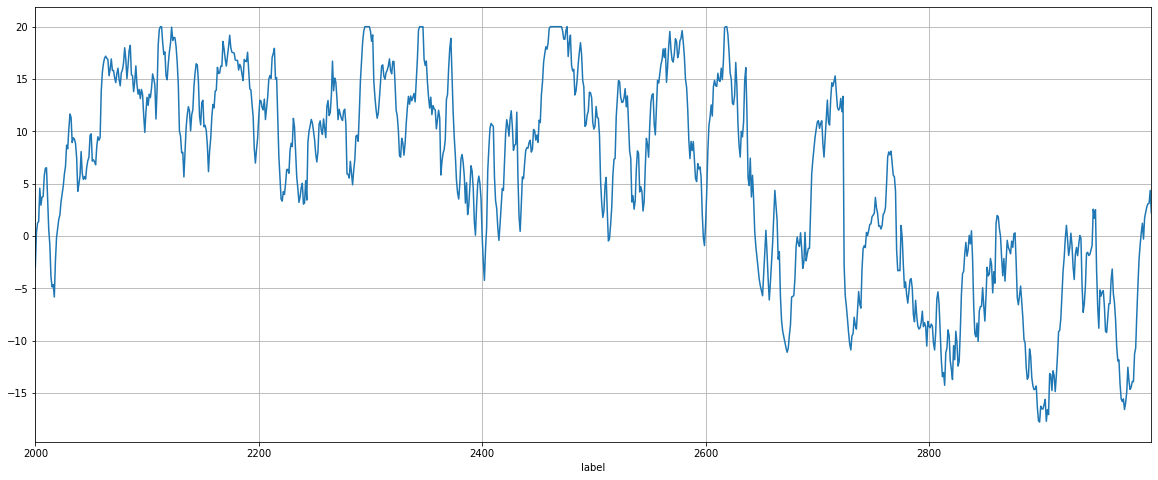

In [46]:
ema_forecast_oos.iloc[2000:3000].plot(figsize=(20,8), grid=True);

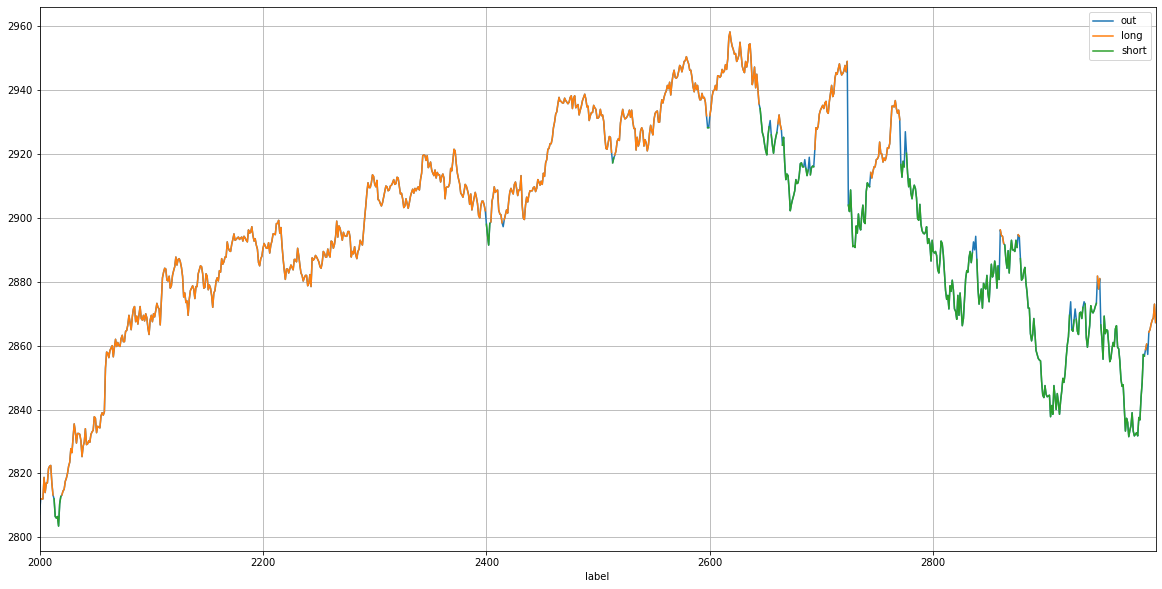

In [47]:
chart_price(vol_candles_oos.close.iloc[2000:3000], ema_forecast_oos.iloc[2000:3000], 0);

In [34]:
data = vol_candles_oos.copy()
data['ema'] = ema_forecast_oos
data.set_index('date', inplace=True)

In [35]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 6, 7, 10, 15, 17]: #12, 15, 20]:
    b = v_backtester(data.open, data.ema, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [36]:
stats

,0,5,6,7,10,15,17
Annual return,0.281207,0.150309,0.17657,0.157963,0.0144247,-0.0422111,-0.0261471
Cumulative returns,0.191288,0.103967,0.121711,0.109151,0.0101675,-0.030004,-0.0185407
Annual volatility,0.109867,0.111773,0.10082,0.0955277,0.08255,0.0549815,0.0372017
Sharpe ratio,2.31115,1.30857,1.66322,1.58297,0.214476,-0.757123,-0.69378
Calmar ratio,4.39482,4.09933,5.9352,6.69391,0.298507,-1.04599,-0.700214
Stability,0.868111,0.79665,0.87604,0.895039,0.205587,0.559312,0.550971
Max drawdown,-0.063986,-0.0366667,-0.0297496,-0.0235979,-0.0483229,-0.0403552,-0.0373415
Omega ratio,1.50244,1.25382,1.34597,1.34286,1.04282,0.821921,0.80347
Sortino ratio,3.65609,2.07828,2.89859,2.82159,0.324626,-1.18,-1.22108
Skew,0.0958075,0.495735,1.01579,1.22137,0.457096,2.00595,4.19537


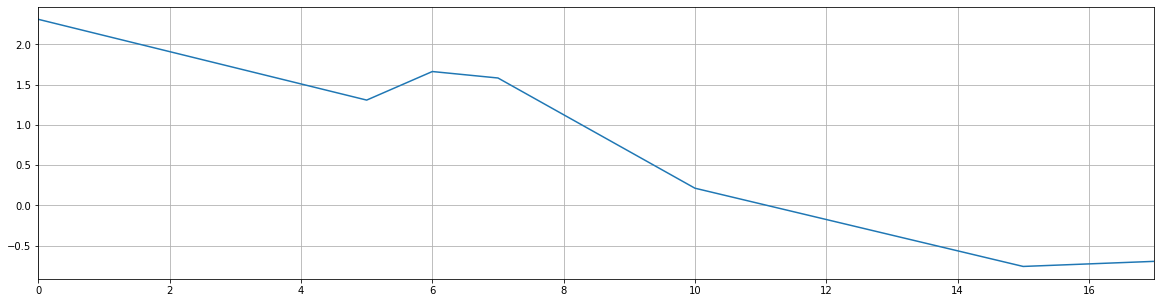

In [37]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [38]:
returns.corr()

,0,5,6,7,10,15,17
0,1.000000,0.799474,0.768071,0.754320,0.565757,0.333644,0.343843
5,0.799474,1.000000,0.952004,0.923440,0.743510,0.386504,0.374068
6,0.768071,0.952004,1.000000,0.948836,0.769362,0.417192,0.414425
7,0.754320,0.923440,0.948836,1.000000,0.804859,0.463230,0.442082
10,0.565757,0.743510,0.769362,0.804859,1.000000,0.582011,0.499617
15,0.333644,0.386504,0.417192,0.463230,0.582011,1.000000,0.814381
17,0.343843,0.374068,0.414425,0.442082,0.499617,0.814381,1.000000


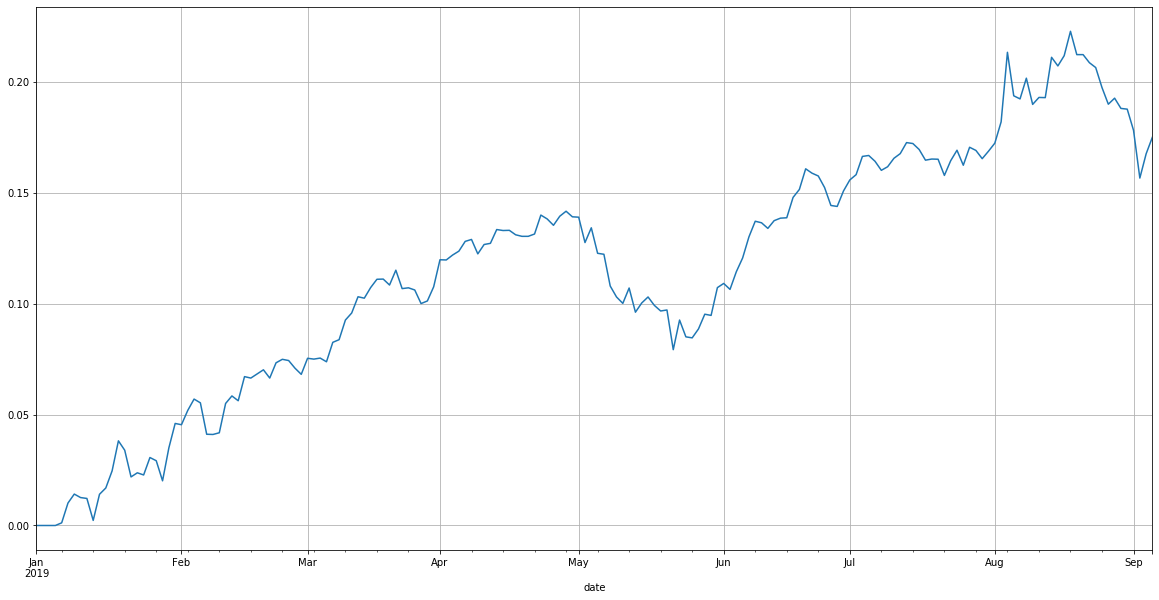

In [39]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

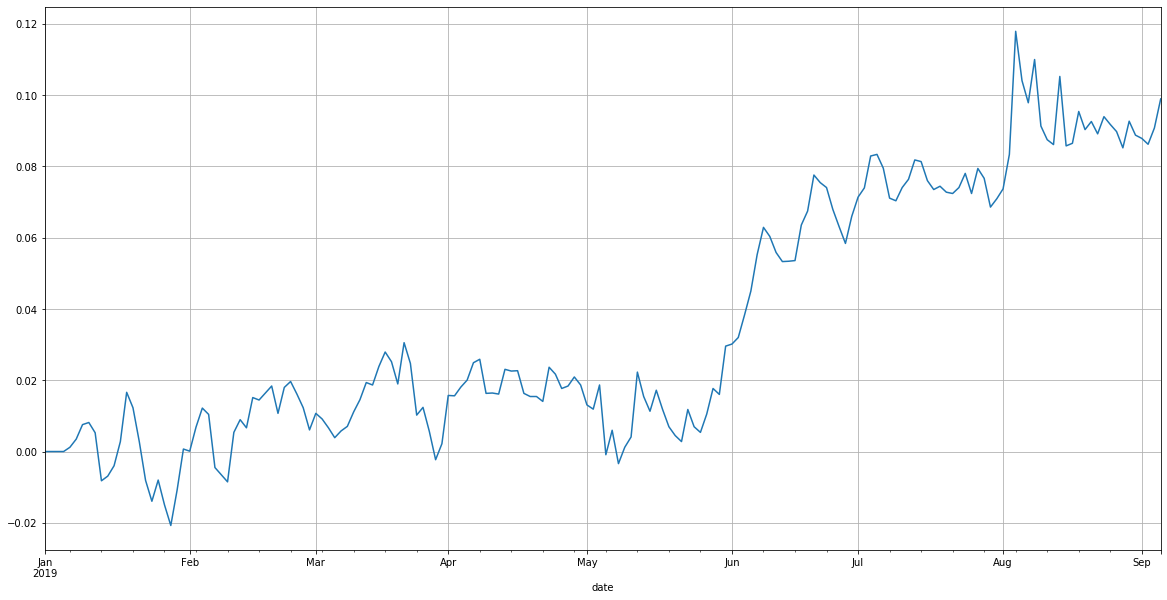

In [40]:
np.log(returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

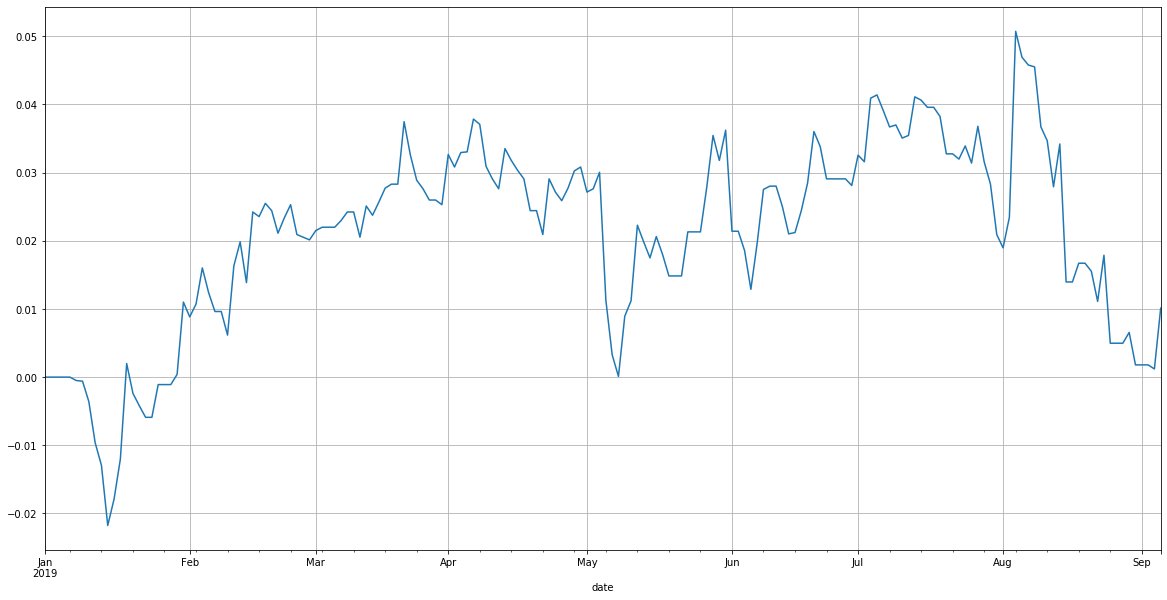

In [41]:
np.log(returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
b = v_backtester(data.open, data.ema, i)
r = perf_var(b, False)